# run wind-up analysis on the open source smarteole data

In [1]:
import sys
from pathlib import Path

import pandas as pd

from wind_up.constants import PROJECTROOT_DIR
from wind_up.interface import AssessmentInputs
from wind_up.main_analysis import run_wind_up_analysis
from wind_up.models import PlotConfig
from wind_up.reanalysis_data import ReanalysisDataset

sys.path.append(str(PROJECTROOT_DIR))
from examples.helpers import download_zenodo_data


## configure logger so wind-up log messages are displayed in this notebook

In [2]:
import logging
import re
from IPython.display import display, Markdown
logging.basicConfig(format='%(message)s', level=logging.INFO)

class NotebookHandler(logging.Handler):
    def emit(self, record):
        message = self.format(record)
        # Replace newline characters with <br> tags
        message = re.sub(r'\n', '<br>', message)
        display(Markdown(message))

logger = logging.getLogger()
logger.handlers = []  # Clear existing handlers to avoid duplication
logger.addHandler(NotebookHandler())

## download the smarteole data from zenodo

In [3]:
from examples.smarteole_example import ZIP_FILENAME, CACHE_DIR
download_zenodo_data(record_id="7342466", output_dir=CACHE_DIR, filenames={ZIP_FILENAME})

File C:\Users\aclerc\Documents\GitHub\wind-up\cache\smarteole_example_data\SMARTEOLE-WFC-open-dataset.zip already exists. Skipping download.

## organize wind farm scada data as a pandas dataframe

In [4]:
from examples.smarteole_example import ANALYSIS_TIMEBASE_S, unpack_smarteole_scada

scada_df = unpack_smarteole_scada(ANALYSIS_TIMEBASE_S)
scada_df.head()

TurbineName  ActivePowerMean  ActivePowerSD  \
TimeStamp_StartFormat                                               
2020-02-17 16:30:00          SMV1        2017.8566        57.0837   
2020-02-17 16:40:00          SMV1        1946.2472        91.7614   
2020-02-17 16:50:00          SMV1        1946.5069        98.3934   
2020-02-17 17:00:00          SMV1        1828.9365       139.5910   
2020-02-17 17:10:00          SMV1        1751.7035       170.2128   

                       WindSpeedMean  WindSpeedSD  YawAngleMean  YawAngleMin  \
TimeStamp_StartFormat                                                          
2020-02-17 16:30:00          13.6164       1.2411    247.884662      239.930   
2020-02-17 16:40:00          13.0139       1.0178    259.686000      259.686   
2020-02-17 16:50:00          12.5818       0.9482    259.686000      259.686   
2020-02-17 17:00:00          11.6641       0.9244    252.924035      249.808   
2020-02-17 17:10:00          11.3144       1.0116    249.808000      249.808   

                       YawAngleMax  PitchAngleMean  GenRpmMean  AmbientTemp  \
TimeStamp_StartFormat                                                         
2020-02-17 16:30:00        259.686          6.0648   1800.5394      11.6191   
2020-02-17 16:40:00        259.686          3.5153   1798.7652      11.5493   
2020-02-17 16:50:00        259.686          2.1367   1799.5171      11.4929   
2020-02-17 17:00:00        259.686          0.8526   1799.4533      11.4735   
2020-02-17 17:10:00        249.808          0.2404   1799.2136      11.3937   

                       ShutdownDuration  
TimeStamp_StartFormat                    
2020-02-17 16:30:00                   0  
2020-02-17 16:40:00                   0  
2020-02-17 16:50:00                   0  
2020-02-17 17:00:00                   0  
2020-02-17 17:10:00                   0

## organize wind farm meta data (such as lat long) as a pandas dataframe

In [5]:
from examples.smarteole_example import unpack_smarteole_metadata
metadata_df = unpack_smarteole_metadata(ANALYSIS_TIMEBASE_S)
metadata_df.head()

Name  Latitude  Longitude TimeZone  TimeSpanMinutes TimeFormat
0  SMV1  49.84975    2.80194      UTC               10      Start
1  SMV2  49.84661    2.80150      UTC               10      Start
2  SMV3  49.84347    2.80162      UTC               10      Start
3  SMV4  49.84033    2.80122      UTC               10      Start
4  SMV5  49.83719    2.80080      UTC               10      Start

## organize toggle data as a pandas dataframe
toggle data is data from the controller running the toggle test, in this case a wake steering controller

In [6]:
from examples.smarteole_example import unpack_smarteole_toggle_data
toggle_df = unpack_smarteole_toggle_data(ANALYSIS_TIMEBASE_S)
toggle_df.head()

toggle_on  toggle_off  yaw_offset_command
TimeStamp_StartFormat                                               
2020-02-17 16:30:00+00:00      False        True                 0.0
2020-02-17 16:40:00+00:00      False        True                 0.0
2020-02-17 16:50:00+00:00      False        True                 0.0
2020-02-17 17:00:00+00:00       True       False                 0.0
2020-02-17 17:10:00+00:00       True       False                 0.0

## merge the yaw offset command data into the scada data
this is not stricty necessary but means the yaw offset command data is available for plotting during analysis

In [7]:
toggle_df_no_tz = toggle_df.copy()
toggle_df_no_tz.index = toggle_df_no_tz.index.tz_localize(None)
scada_df = scada_df.merge(toggle_df_no_tz["yaw_offset_command"], left_index=True, right_index=True, how="left")
scada_df["yaw_offset_command"] = scada_df["yaw_offset_command"].where(scada_df["TurbineName"] == "SMV6", 0)
del toggle_df_no_tz
scada_df[["TurbineName","ActivePowerMean","yaw_offset_command"]].head()

TurbineName  ActivePowerMean  yaw_offset_command
TimeStamp_StartFormat                                                 
2020-02-17 16:30:00          SMV1        2017.8566                 0.0
2020-02-17 16:40:00          SMV1        1946.2472                 0.0
2020-02-17 16:50:00          SMV1        1946.5069                 0.0
2020-02-17 17:00:00          SMV1        1828.9365                 0.0
2020-02-17 17:10:00          SMV1        1751.7035                 0.0

example data with yaw_offset_command > 0

In [8]:
scada_df.loc[(scada_df["TurbineName"]=="SMV6") & (scada_df.index > pd.Timestamp("2020-02-18 19:00")),["TurbineName","ActivePowerMean","yaw_offset_command"]].head()

TurbineName  ActivePowerMean  yaw_offset_command
TimeStamp_StartFormat                                                 
2020-02-18 19:10:00          SMV6        1164.0942             19.8272
2020-02-18 19:20:00          SMV6        1533.1757             18.9361
2020-02-18 19:30:00          SMV6        1734.7691             12.5647
2020-02-18 19:40:00          SMV6        1860.2886              9.6538
2020-02-18 19:50:00          SMV6        1778.6030              9.8110

## get nearby reanalysis data
Can be from any source. ERA5T is generally very helpful for wind-up analysis

In [9]:
reanalysis_dataset = ReanalysisDataset(
        id="ERA5T_50.00N_2.75E_100m_1hr",
        data=pd.read_parquet(Path("smarteole_data")/ "ERA5T_50.00N_2.75E_100m_1hr_20200201_20200531.parquet"),
    )
reanalysis_dataset.data.head()

10_m_hws_mean_mps  10_m_hwd_mean_deg-n_true  \
datetime_start_utc                                                       
2020-02-01 00:00:00+00:00               6.29                     203.1   
2020-02-01 01:00:00+00:00               6.57                     204.3   
2020-02-01 02:00:00+00:00               6.54                     209.5   
2020-02-01 03:00:00+00:00               6.29                     216.2   
2020-02-01 04:00:00+00:00               6.06                     220.8   

                           100_m_hws_mean_mps  100_m_hwd_mean_deg-n_true  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00               10.33                      206.6   
2020-02-01 01:00:00+00:00               10.80                      207.4   
2020-02-01 02:00:00+00:00               10.69                      212.1   
2020-02-01 03:00:00+00:00               10.25                      218.9   
2020-02-01 04:00:00+00:00                9.81                      223.6   

                           2_m_temp_mean_deg-c  2_m_dew_point_temp_deg-c  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00                 11.6                       9.8   
2020-02-01 01:00:00+00:00                 11.6                      10.2   
2020-02-01 02:00:00+00:00                 11.6                      10.7   
2020-02-01 03:00:00+00:00                 11.6                      11.1   
2020-02-01 04:00:00+00:00                 11.6                      11.3   

                           2_m_rh_mean_%  0_m_pres_mean_pa  \
datetime_start_utc                                           
2020-02-01 00:00:00+00:00           88.9           99621.8   
2020-02-01 01:00:00+00:00           91.2           99547.5   
2020-02-01 02:00:00+00:00           93.9           99486.1   
2020-02-01 03:00:00+00:00           96.4           99432.0   
2020-02-01 04:00:00+00:00           97.9           99341.0   

                           sea_level_pres_mean_pa  boundary_layer_height_m  \
datetime_start_utc                                                           
2020-02-01 00:00:00+00:00                100815.6                    834.2   
2020-02-01 01:00:00+00:00                100739.8                    813.0   
2020-02-01 02:00:00+00:00                100678.0                    808.8   
2020-02-01 03:00:00+00:00                100623.2                    823.8   
2020-02-01 04:00:00+00:00                100530.8                    788.9   

                           total_cloud_cover_%  \
datetime_start_utc                               
2020-02-01 00:00:00+00:00                100.0   
2020-02-01 01:00:00+00:00                100.0   
2020-02-01 02:00:00+00:00                100.0   
2020-02-01 03:00:00+00:00                100.0   
2020-02-01 04:00:00+00:00                100.0   

                           instantaneous_surface_sensible_heat_flux_wpm2  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00                                         30.138   
2020-02-01 01:00:00+00:00                                         33.538   
2020-02-01 02:00:00+00:00                                         32.996   
2020-02-01 03:00:00+00:00                                         27.442   
2020-02-01 04:00:00+00:00                                         22.671   

                           friction_velocity_mps  cloud_base_height_m  \
datetime_start_utc                                                      
2020-02-01 00:00:00+00:00               0.441049                204.6   
2020-02-01 01:00:00+00:00               0.435240                 30.8   
2020-02-01 02:00:00+00:00               0.424339                 30.8   
2020-02-01 03:00:00+00:00               0.411508                 30.8   
2020-02-01 04:00:00+00:00               0.396724                 30.8   

                           surface_solar_radiation_downwards_wpm

## define the wind-up analysis configuration

In [10]:
from examples.smarteole_example import define_smarteole_example_config

cfg = define_smarteole_example_config()
plot_cfg = PlotConfig(show_plots=True, save_plots=False, skip_per_turbine_plots=True, plots_dir=cfg.out_dir / "plots")

loaded WindUpConfig assessment_name: smarteole_example

toggle analysis period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

long term period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

detrend period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

## create the assessment inputs object
This object bundles everything needed to run the wind-up analysis
In particular the wind farm SCADA data is filtered and northed.
A wind speed estimate for each turbine is also derived mainly from power so that the anemometer data is used as little as possible.  

running wind_up analysis for smarteole_example

running load_smart_scada_and_md_from_file for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:50:00+00:00

loaded 7 turbines, 0.3 years per turbine

finished load_smart_scada_and_md for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:50:00+00:00

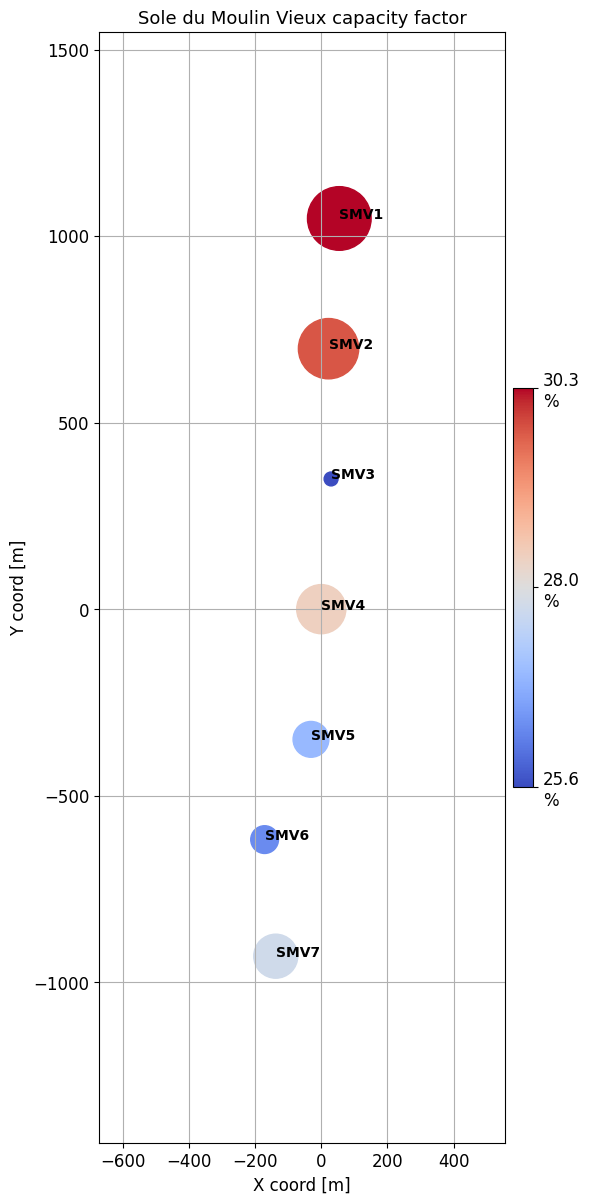

average capacity factor: 27.9%

top 3 capacity factor [%]:<br>+------+------+<br>| SMV1 | 30.3 |<br>| SMV2 | 29.8 |<br>| SMV4 | 28.3 |<br>+------+------+

bottom 3 capacity factor [%]:<br>+------+------+<br>| SMV3 | 25.6 |<br>| SMV6 | 26.3 |<br>| SMV5 | 26.9 |<br>+------+------+

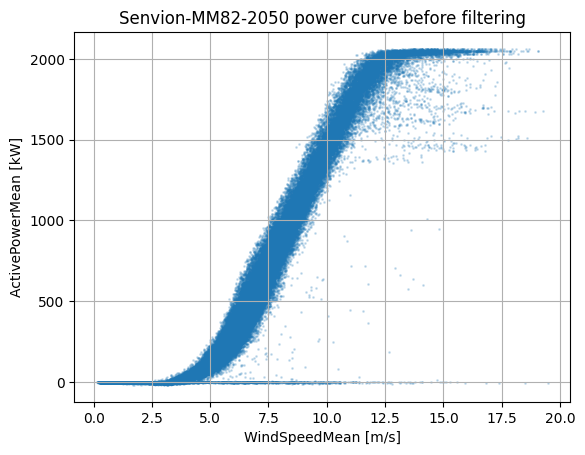

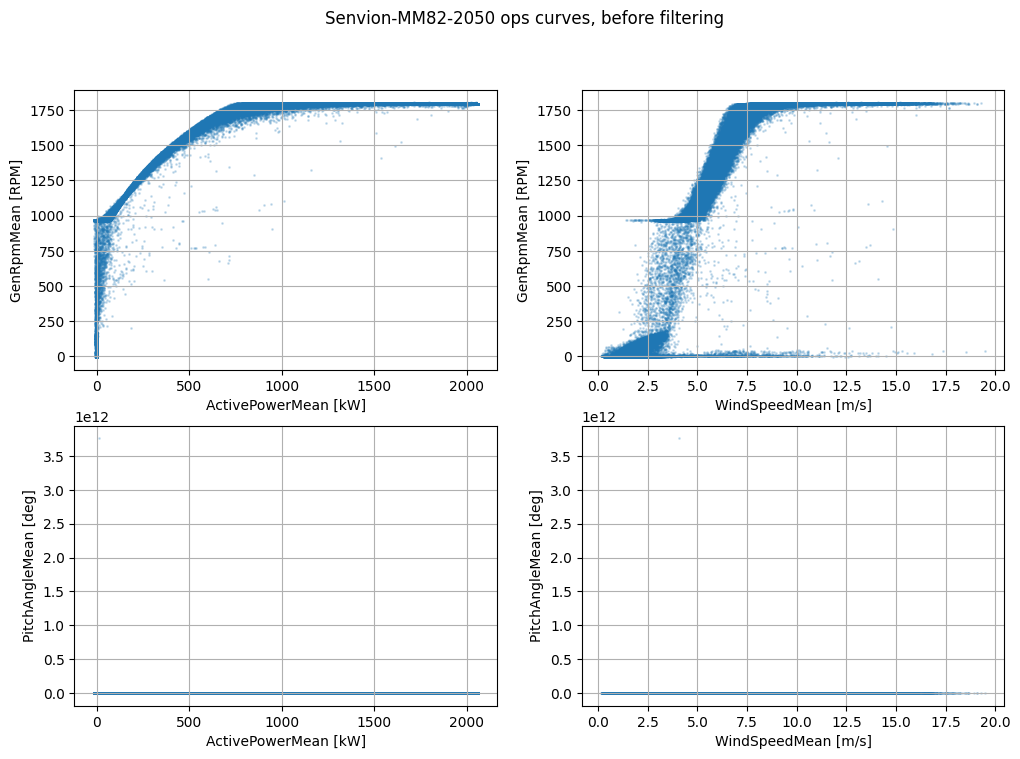

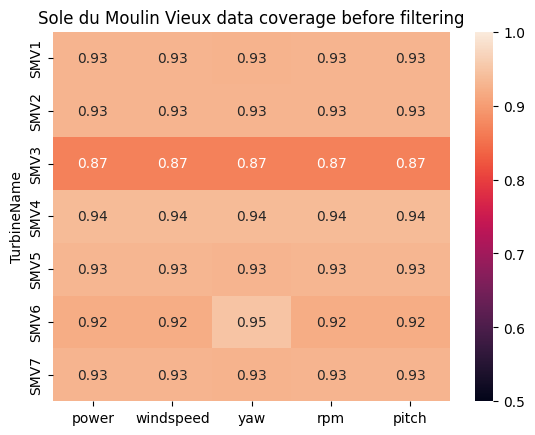

7855 rows [8.0%] of power data is missing before filtering

filter_stuck_data set 0 rows [0.0%] to NA

filter_bad_pw_ws set 0 rows [0.0%] to NA

rows with PitchAngleMean lt -180: 0

rows with PitchAngleMean ge 180: 1

wrapped PitchAngleMean to -180-180

filter_wrong_yaw set 26471 rows [27.0%] to NA yaw Min & Max because of bad YawAngleMin/Max values

filter_wrong_yaw set 232 rows [0.2%] to NA yaw because of YawAngleMean appears to be wrong

filter_exclusions set 0 rows [0.0%] to NA

filter_yaw_exclusions set 0 rows [0.0%] to NA yaw

filter_downtime set 0 rows [0.0%] to NA

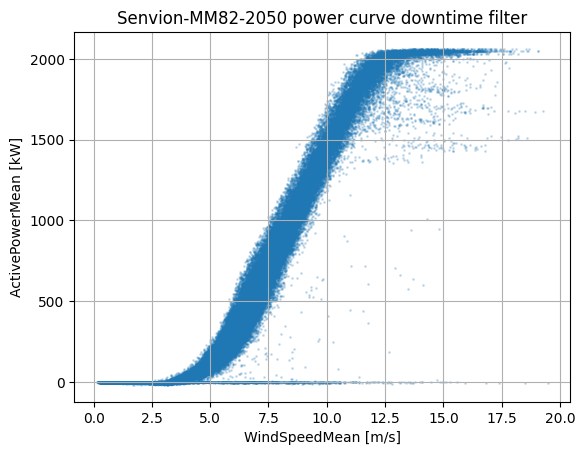

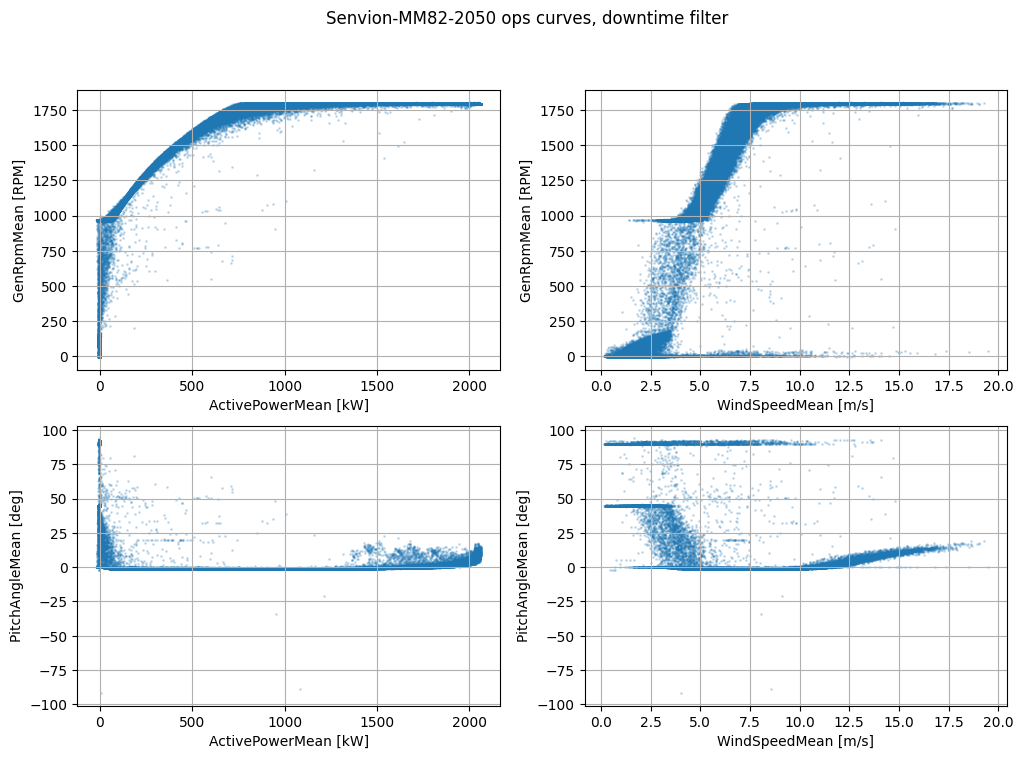

filter_missing_rpm_and_pt set 0 rows [0.0%] to NA because of rpm or pitch are NA

filter_rpm_and_pt set 13598 rows [13.9%] to NA because of rpm or pitch are out of range

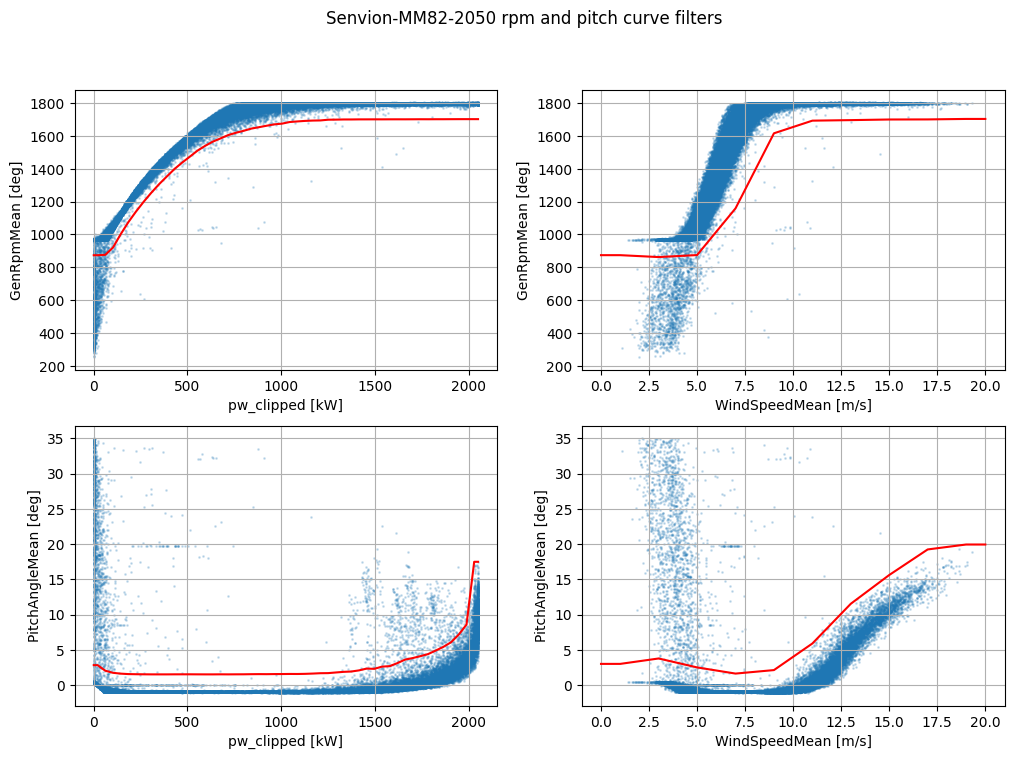

filter_rpm_and_pt set 2663 rows [2.7%] to NA because of rpm or pitch curve filtering

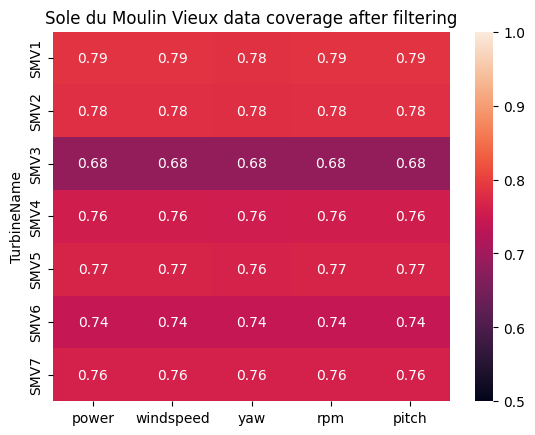

24116 rows [24.6%] of power data is missing after filtering

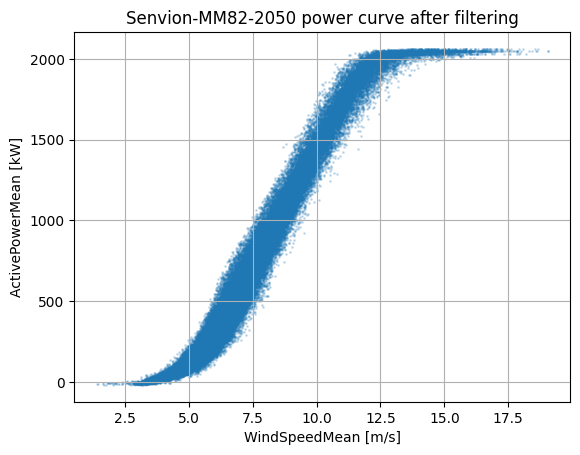

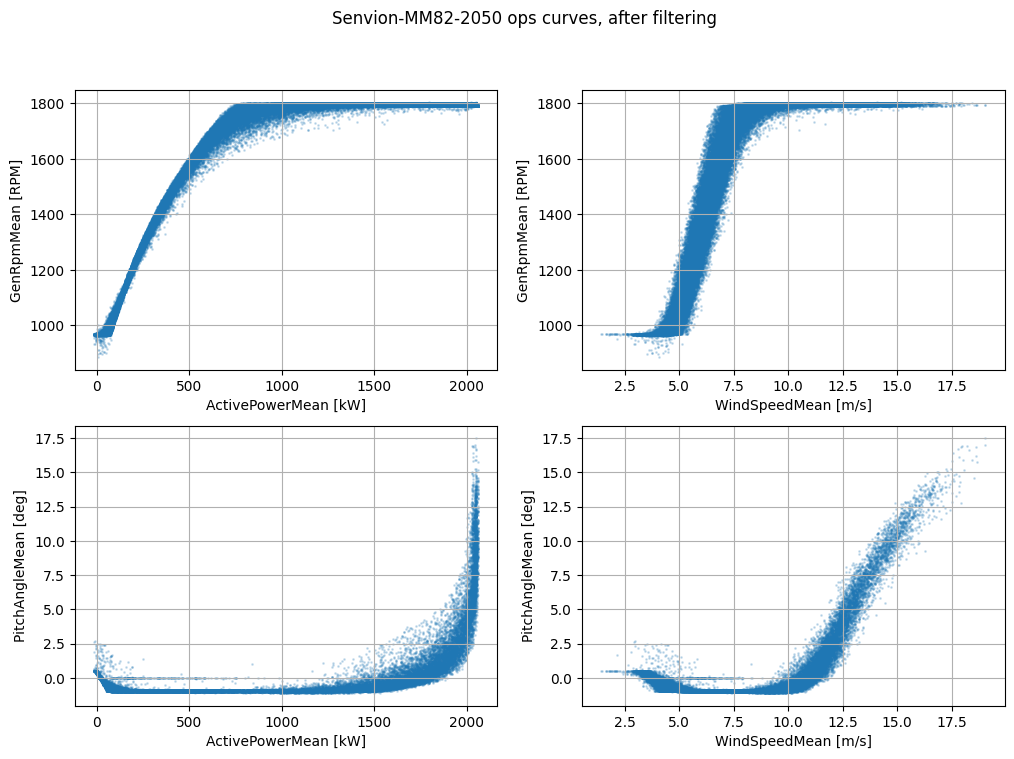

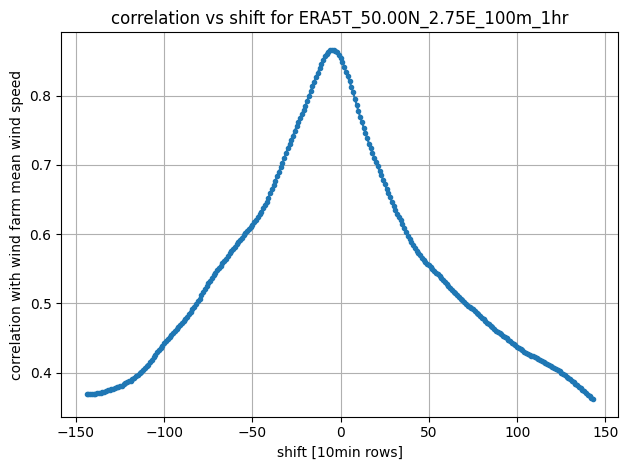

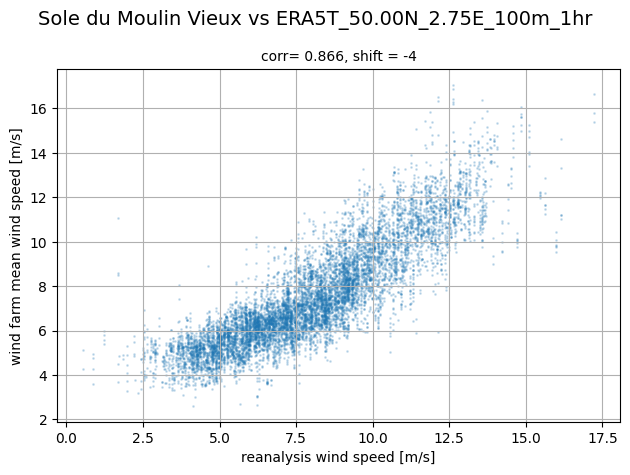

ERA5T_50.00N_2.75E_100m_1hr best correlation is 0.866200 with a shift of -4

ERA5T_50.00N_2.75E_100m_1hr has best correlation: 0.866 with a shift of -4

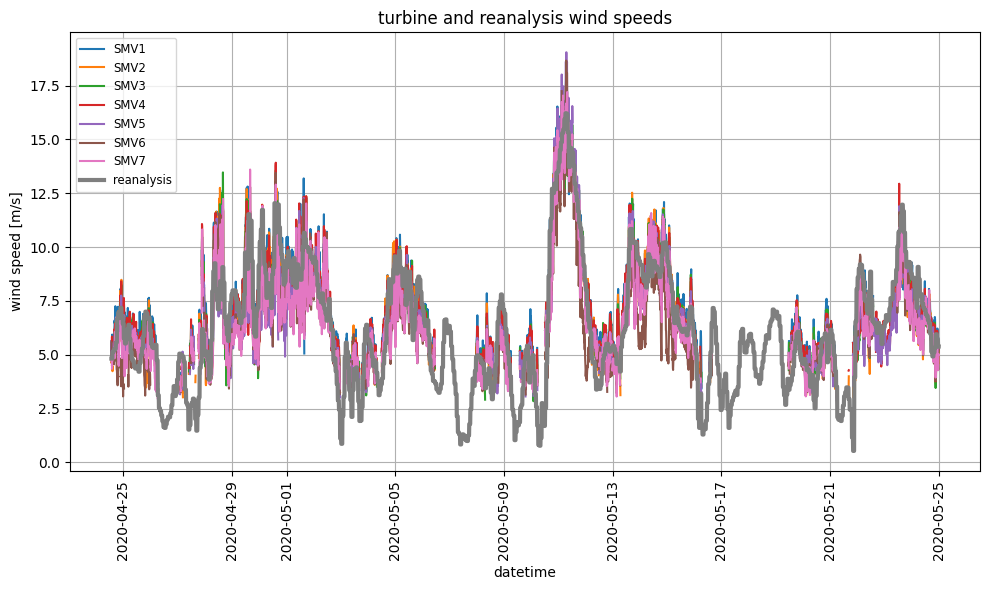

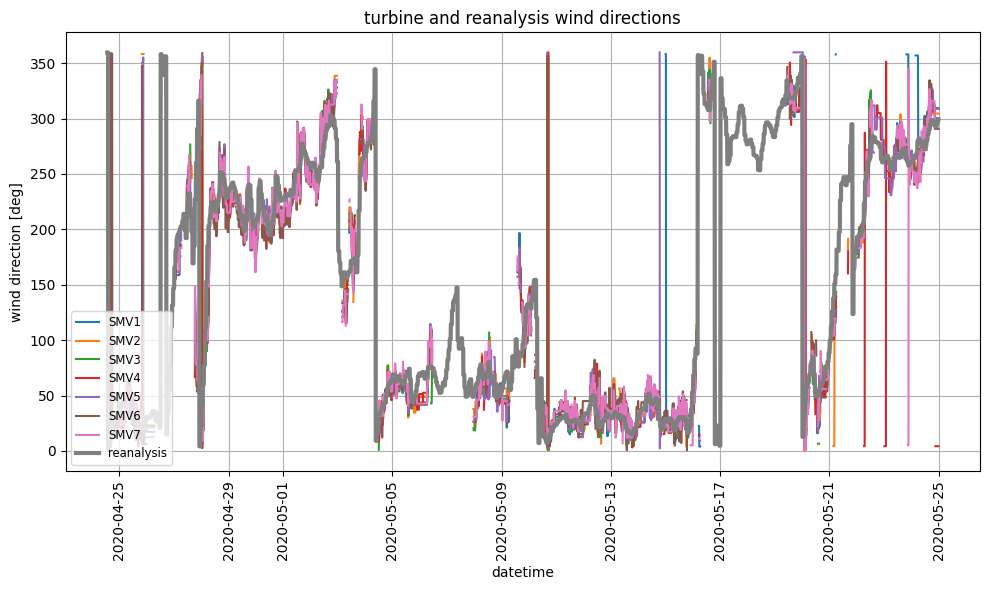

top 3 turbines needing northing correction vs reanalysis_wd before northing:<br>+------+------+<br>| SMV6 | 11.6 |<br>| SMV5 | 11.2 |<br>| SMV3 | 10.3 |<br>+------+------+

top 3 REFERENCE turbines needing northing correction vs reanalysis_wd before northing:<br>+------+-----+<br>| SMV7 | 8.1 |<br>+------+-----+

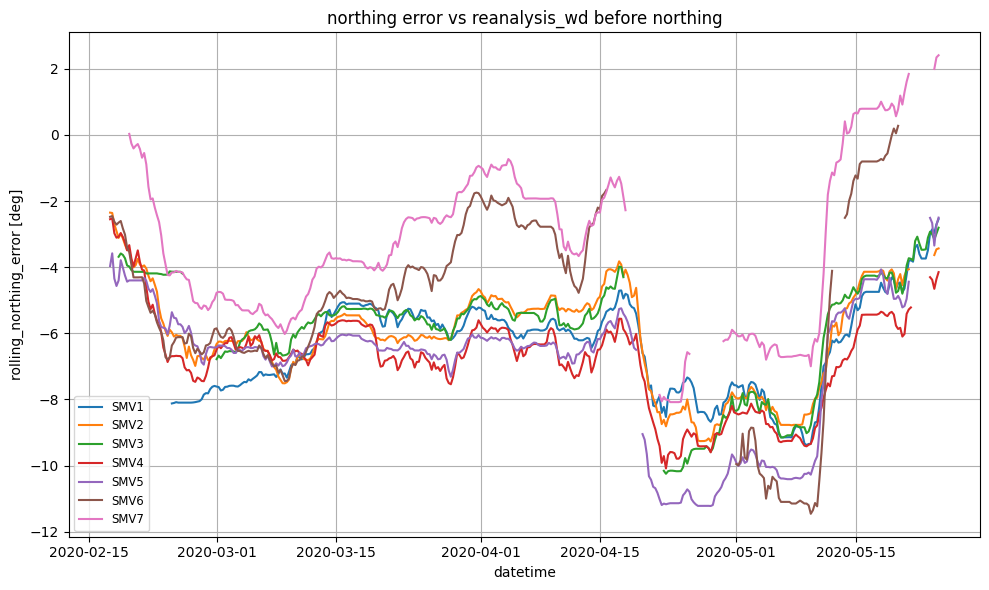

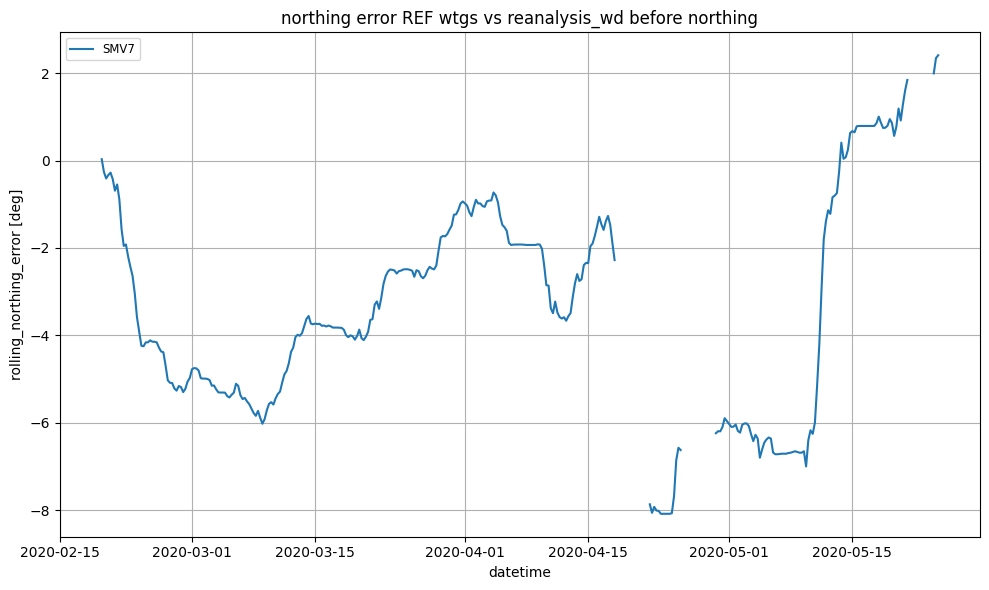

applied 7 northing corrections

top 3 turbines needing northing correction vs reanalysis_wd after northing:<br>+------+-----+<br>| SMV7 | 7.1 |<br>| SMV6 | 6.5 |<br>| SMV3 | 4.7 |<br>+------+-----+

top 3 REFERENCE turbines needing northing correction vs reanalysis_wd after northing:<br>+------+-----+<br>| SMV7 | 7.1 |<br>+------+-----+

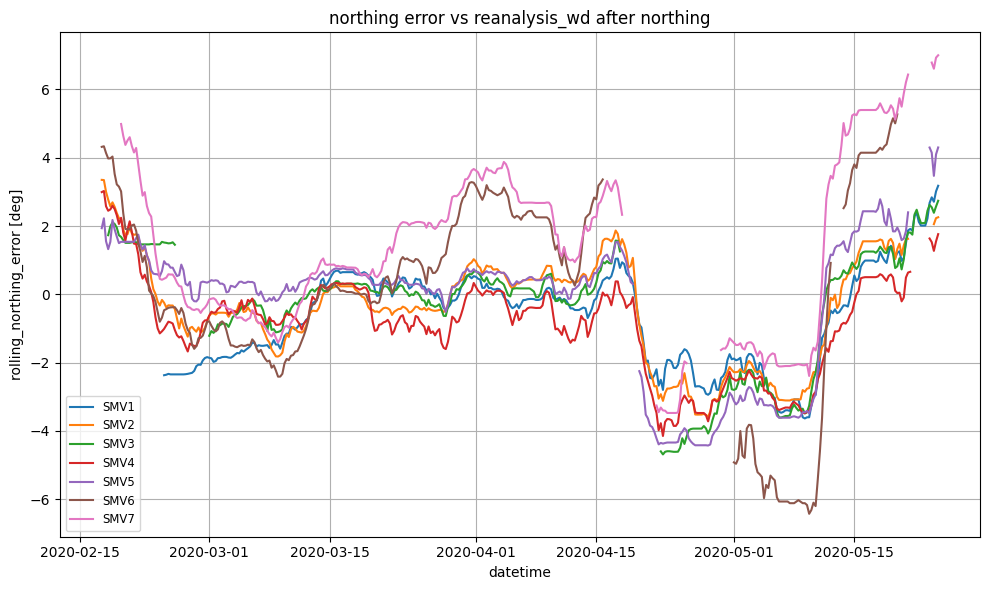

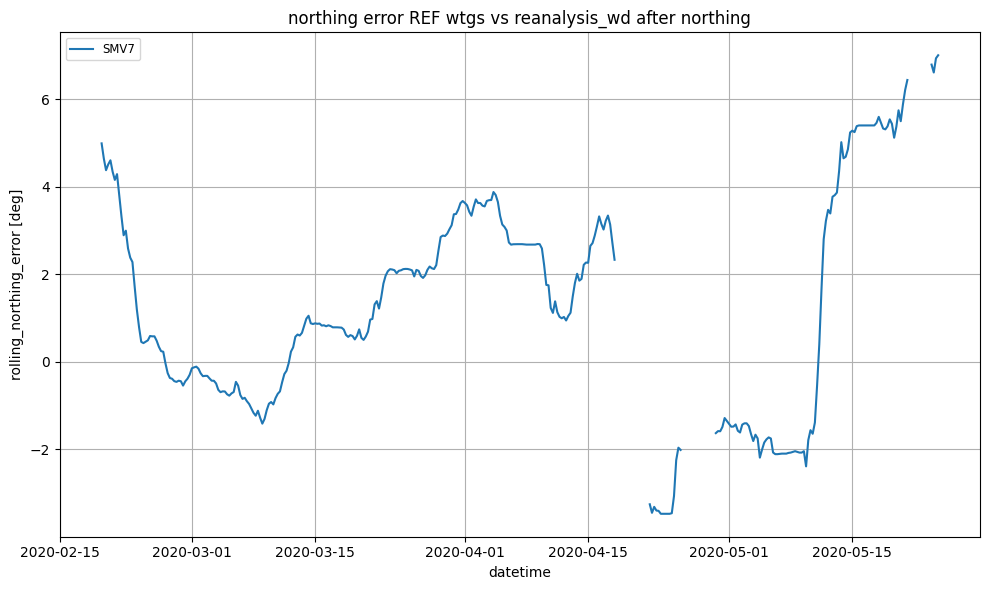

estimated rated wind speed = 14.2 m/s

estimated cut-in wind speed = 3.3 m/s

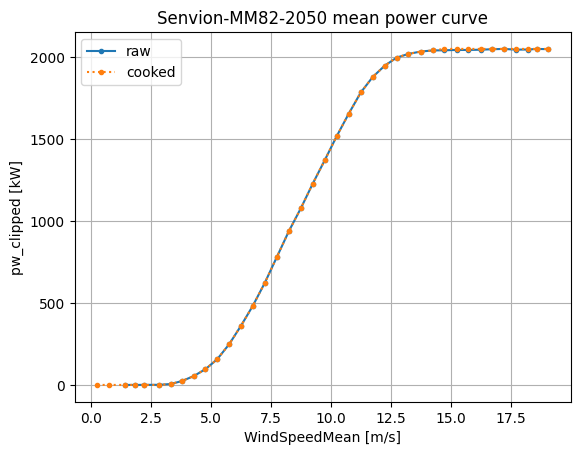

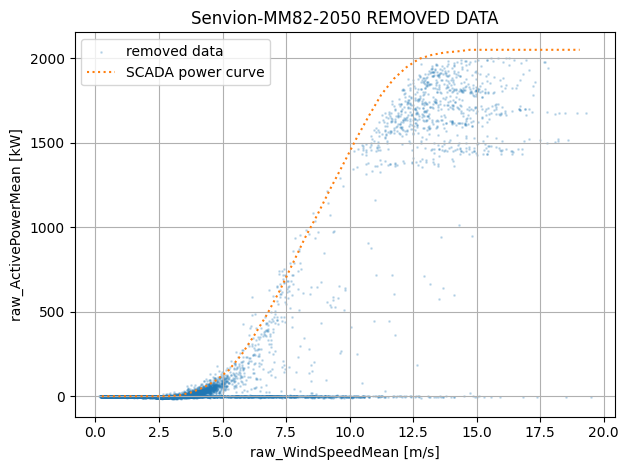

##############################################################################<br># estimate wind speed from power<br>##############################################################################

SMV1 cp correction factor = 0.97

SMV2 cp correction factor = 0.99

SMV3 cp correction factor = 1.00

SMV4 cp correction factor = 0.98

SMV5 cp correction factor = 1.02

SMV6 cp correction factor = 1.03

SMV7 cp correction factor = 1.02

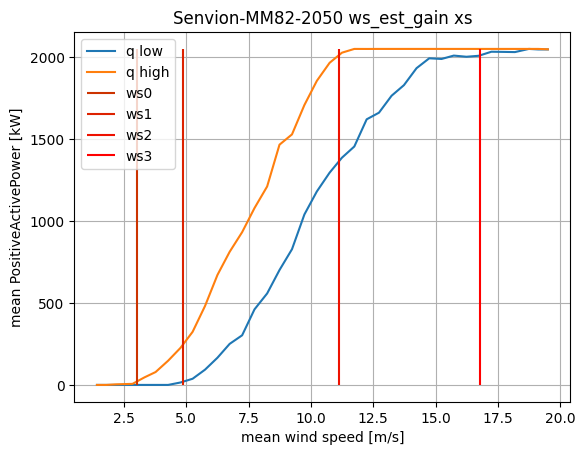

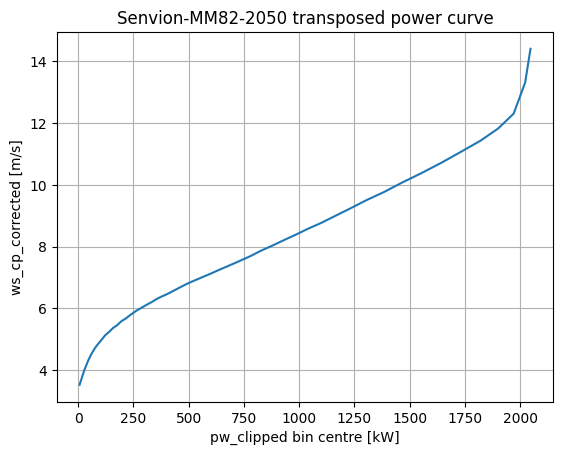

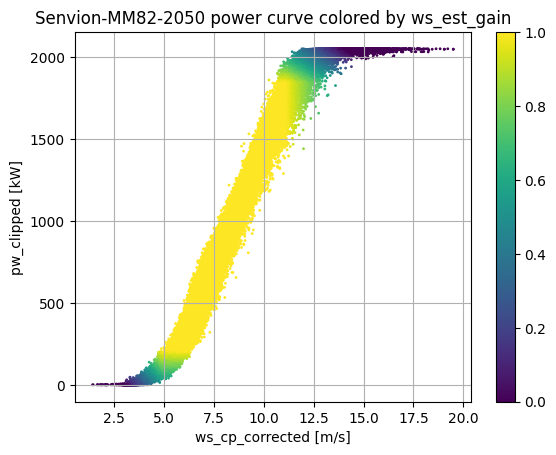

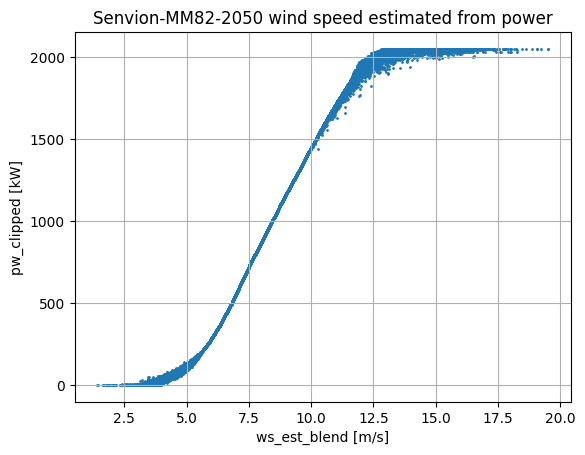

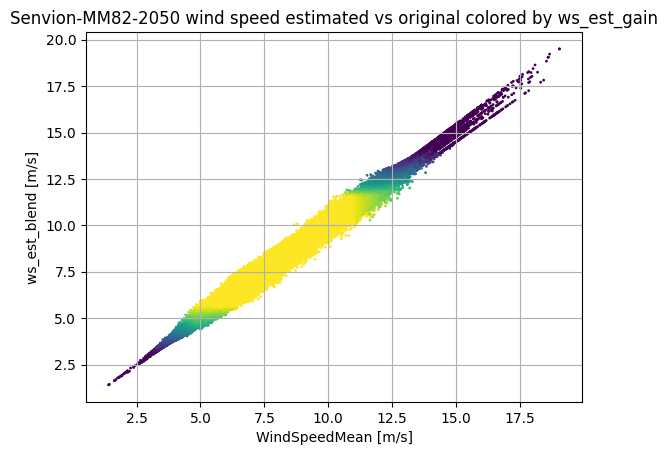

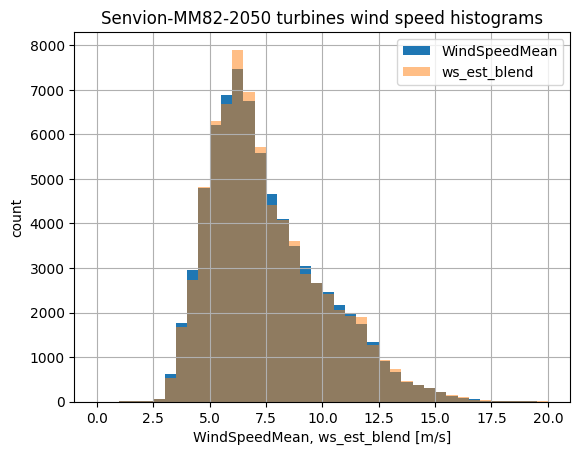

Senvion-MM82-2050 76.1% of rows are waking

Senvion-MM82-2050 14.8% of rows are not waking

Senvion-MM82-2050 9.1% of rows have unknown or partial waking

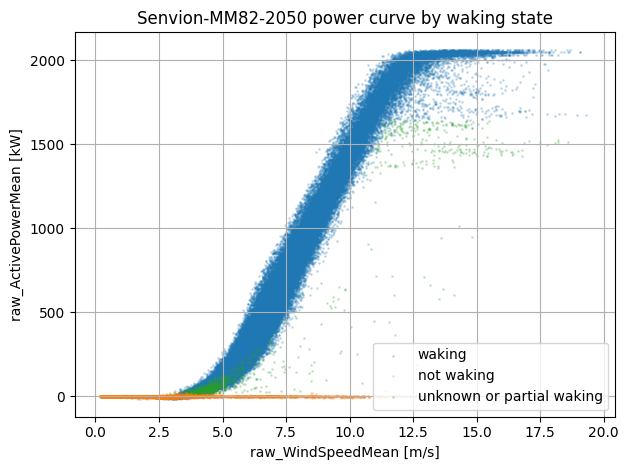

In [11]:
assessment_inputs = AssessmentInputs.from_cfg(
        cfg=cfg,
        plot_cfg=plot_cfg,
        toggle_df=toggle_df,
        scada_df=scada_df,
        metadata_df=metadata_df,
        reanalysis_datasets=[reanalysis_dataset],
        cache_dir=None,
    )

## run the wind-up analysis
The wind-up analysis runs for each test-ref combo, in this case there are two (SMV6-SMV7 and SMV6-SMV7)

test turbines: ['SMV6', 'SMV5']

ref list: ['SMV7']

turbines to test: ['SMV6', 'SMV5']

filter_all_test_wtgs_together SMV5 set 400 rows [2.9%] to NA

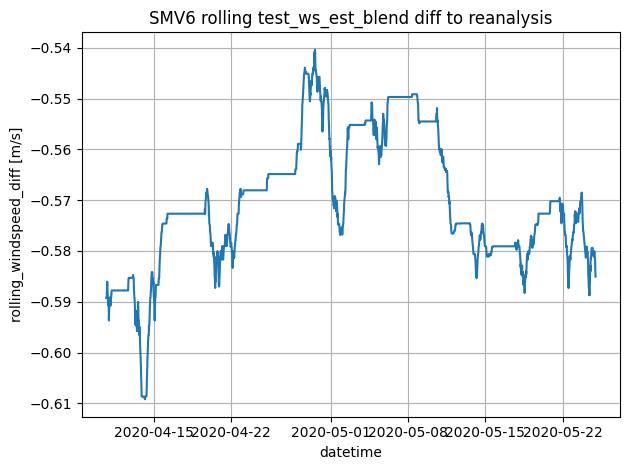

changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

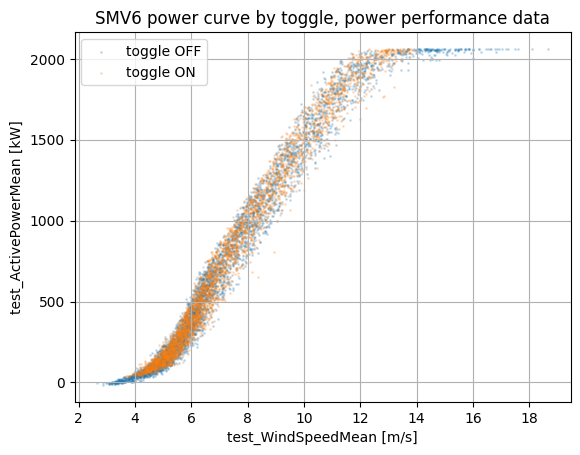

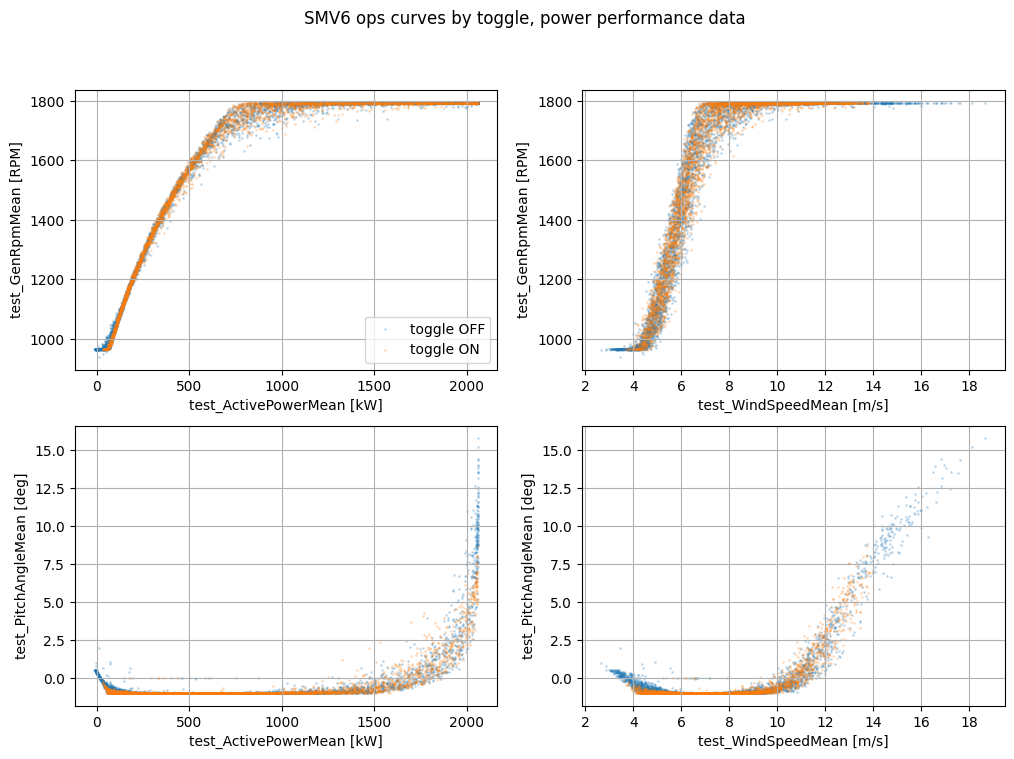

analysing SMV6 SMV7, loop_counter=0

changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

removed 11390 [81.3%] rows from ref_df using ref_wd_filter

SMV7 wake free directions with data min=197.0 max=246.0

removed 0 [0.0%] rows from ref_df using require_ref_wake_free

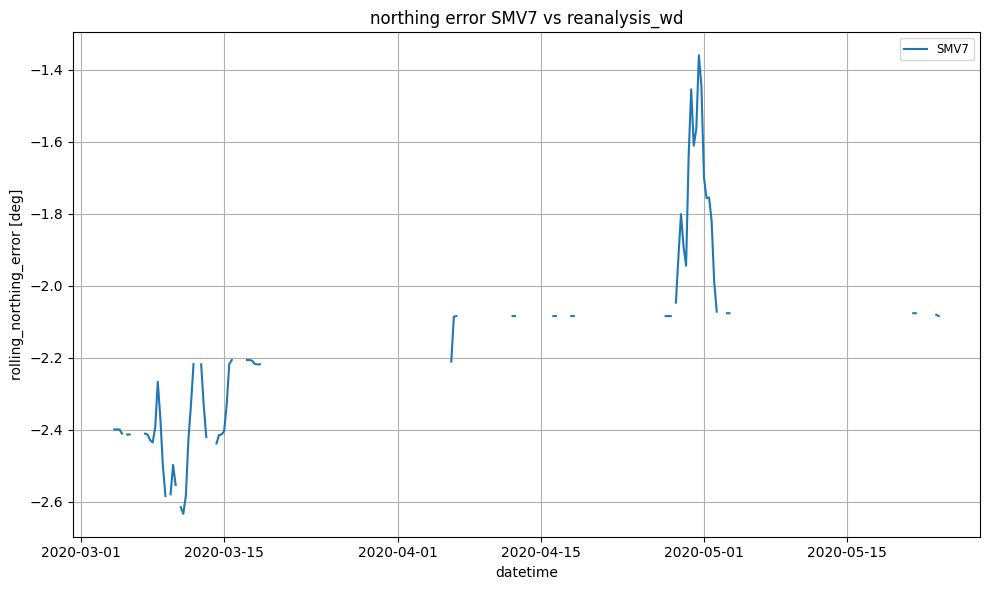

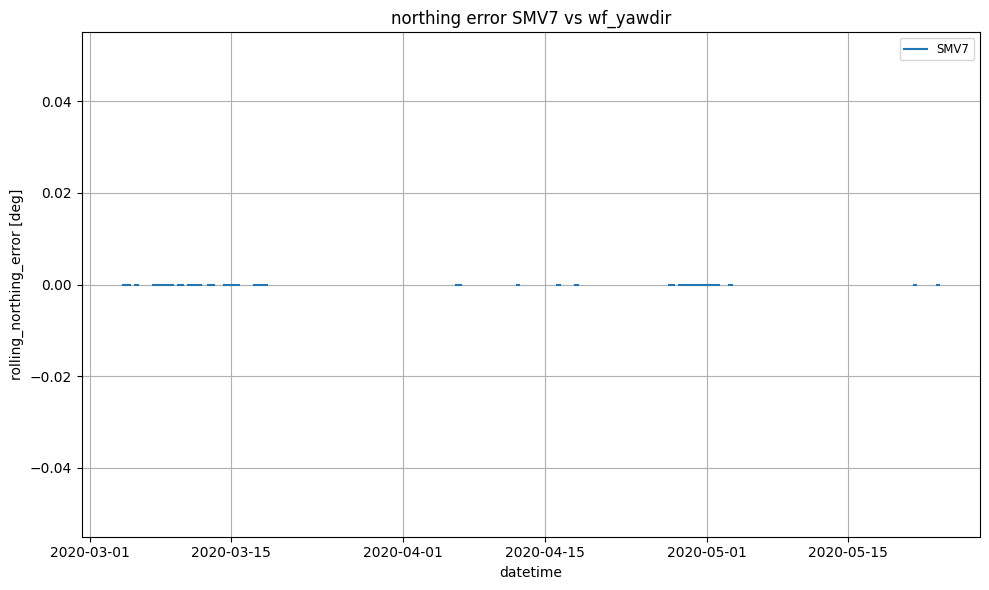

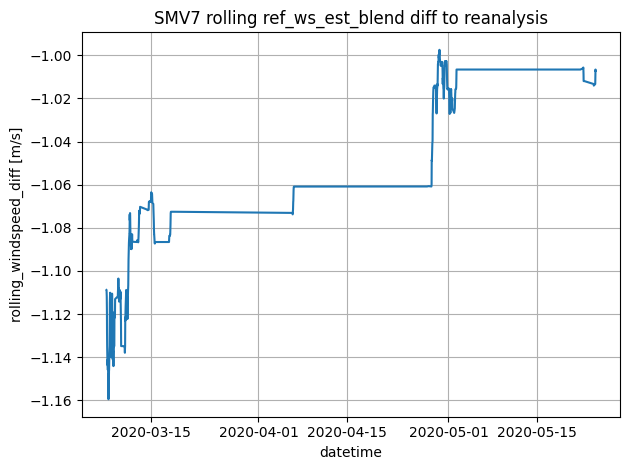

removed 6968 [49.7%] rows from detrend_df where test_toggle_off was not True after the first toggle on time

top 3 SMV6 SMV7 waking scenarios [%]:

+--------------+------+<br>| none offline | 98.2 |<br>| SMV7 offline |  1.6 |<br>| unknown      |  0.2 |<br>+--------------+------+

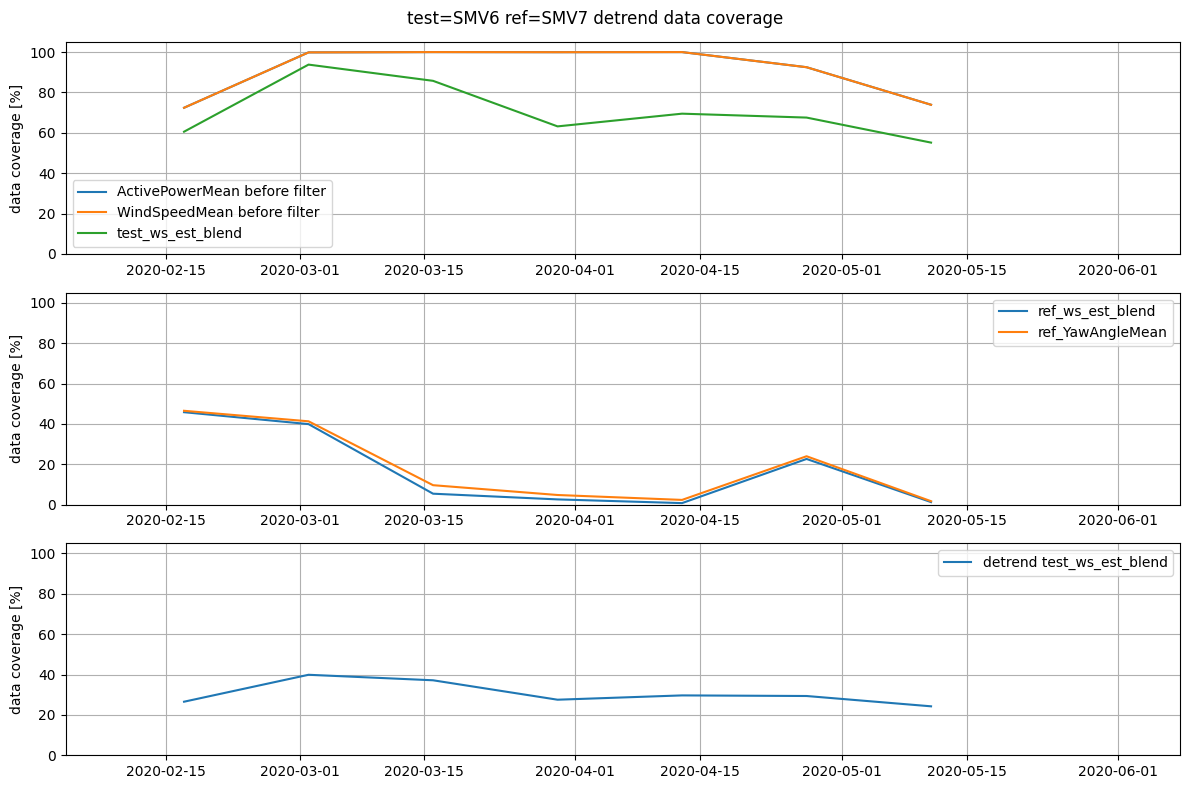

removed 0 bad detrend results

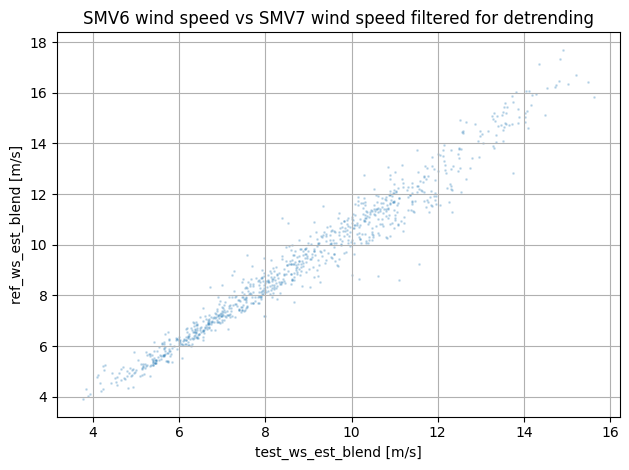

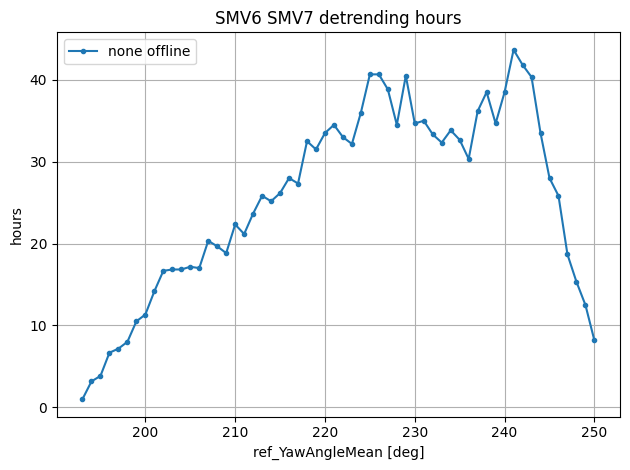

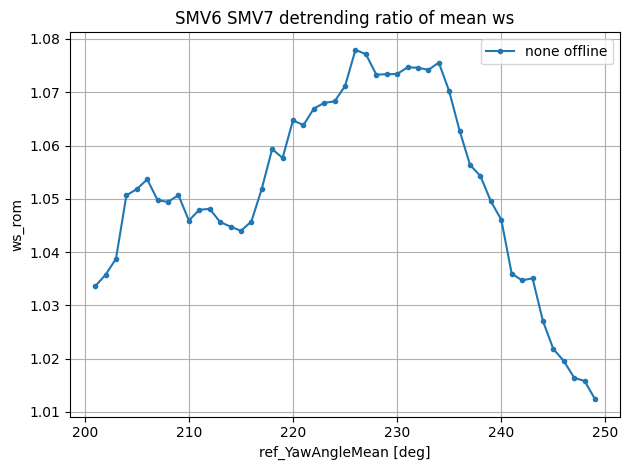

top 3 SMV6 SMV7 waking scenarios [%]:

+--------------+------+<br>| none offline | 98.2 |<br>| SMV7 offline |  1.6 |<br>| unknown      |  0.2 |<br>+--------------+------+

top 1 SMV6 SMV7 waking scenarios [%]:

+--------------+-------+<br>| none offline | 100.0 |<br>+--------------+-------+

detrend applied to 49 scenario - directions

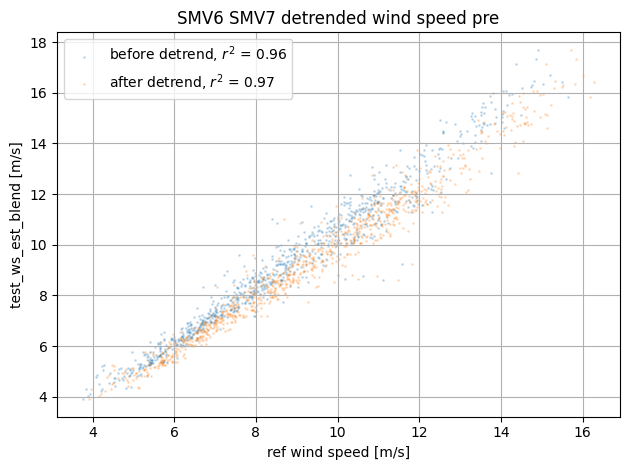

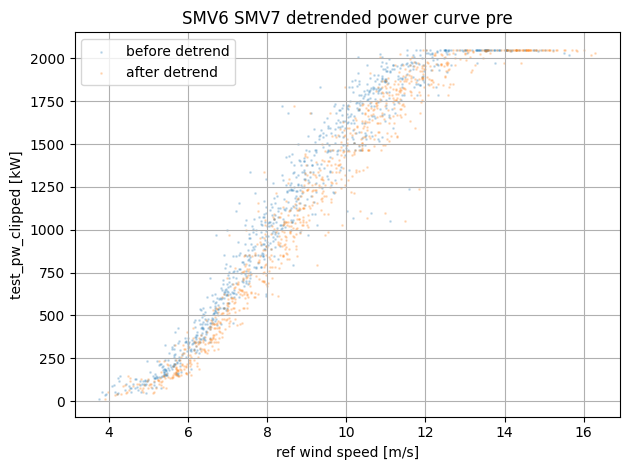

detrend applied to 49 scenario - directions

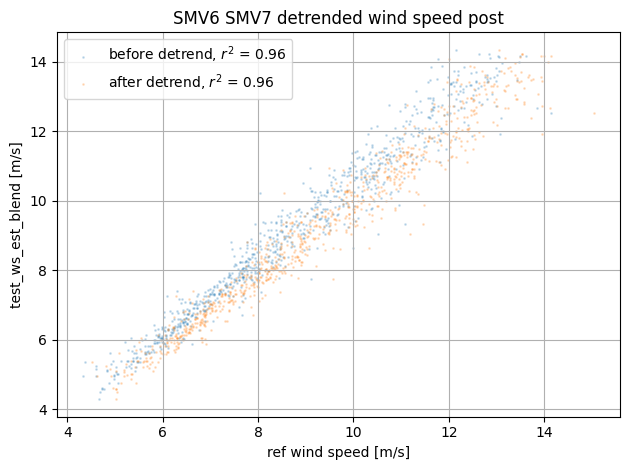

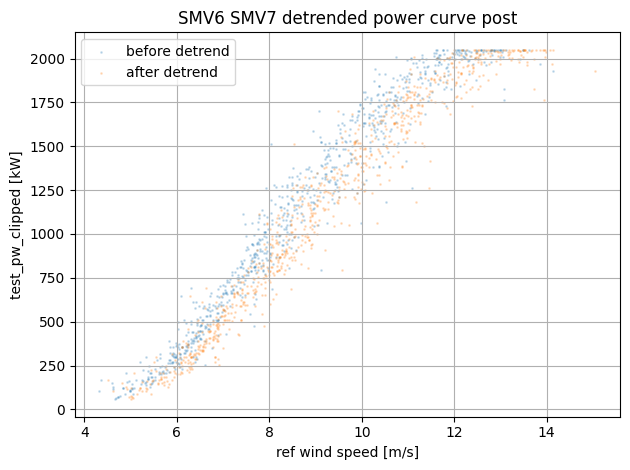

detrend improved pre_df ws r2 by 0.00 (0.96 to 0.97)

detrend improved post_df ws r2 by 0.00 (0.96 to 0.96)

removed 0 bad detrend results

removed 0 bad detrend results

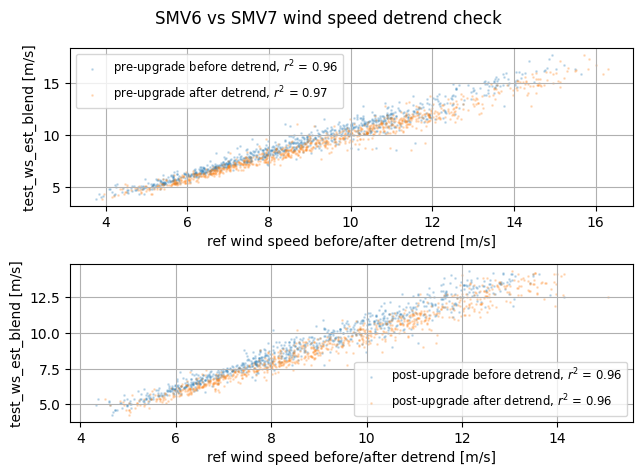

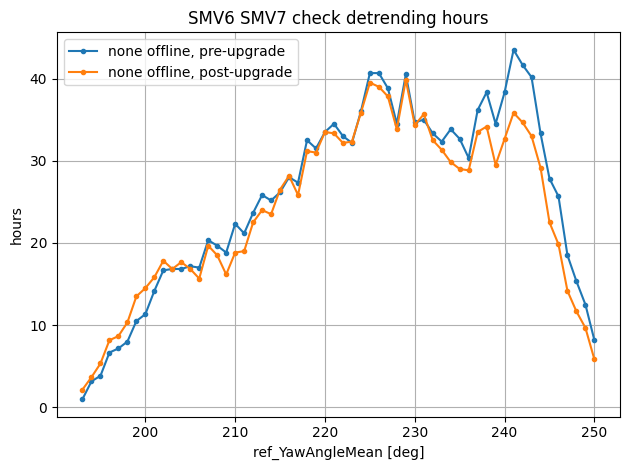

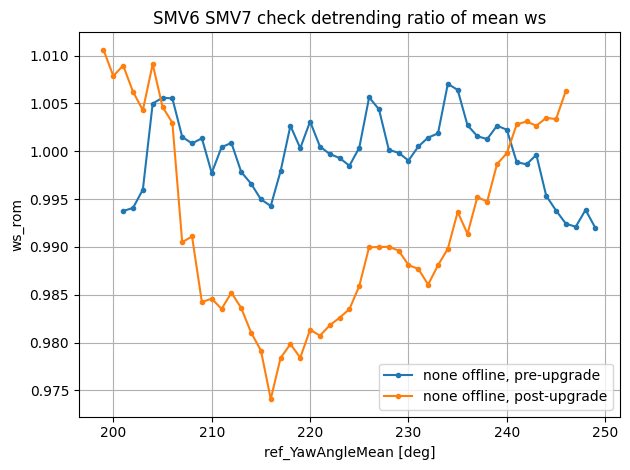

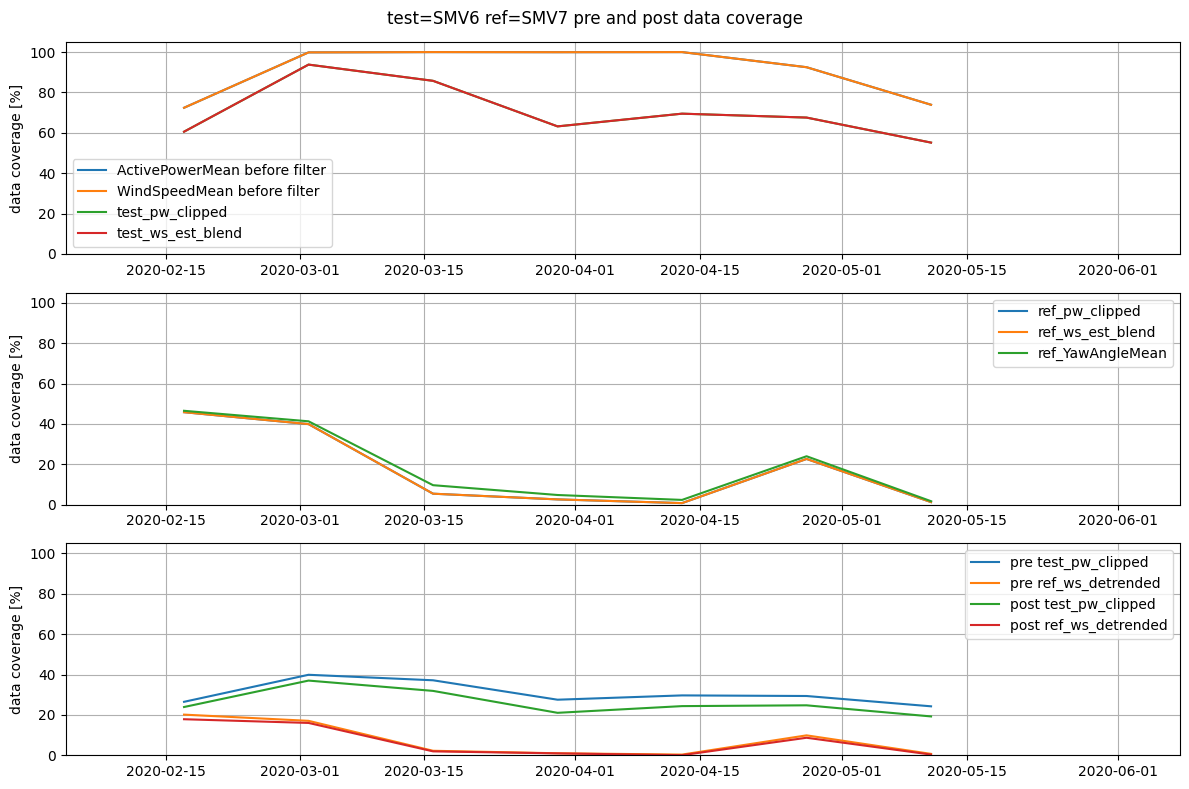

removed 71 [7.8%] rows from pre_df using any_within_timedelta pairing filter

removed 12 [1.4%] rows from post_df using any_within_timedelta pairing filter

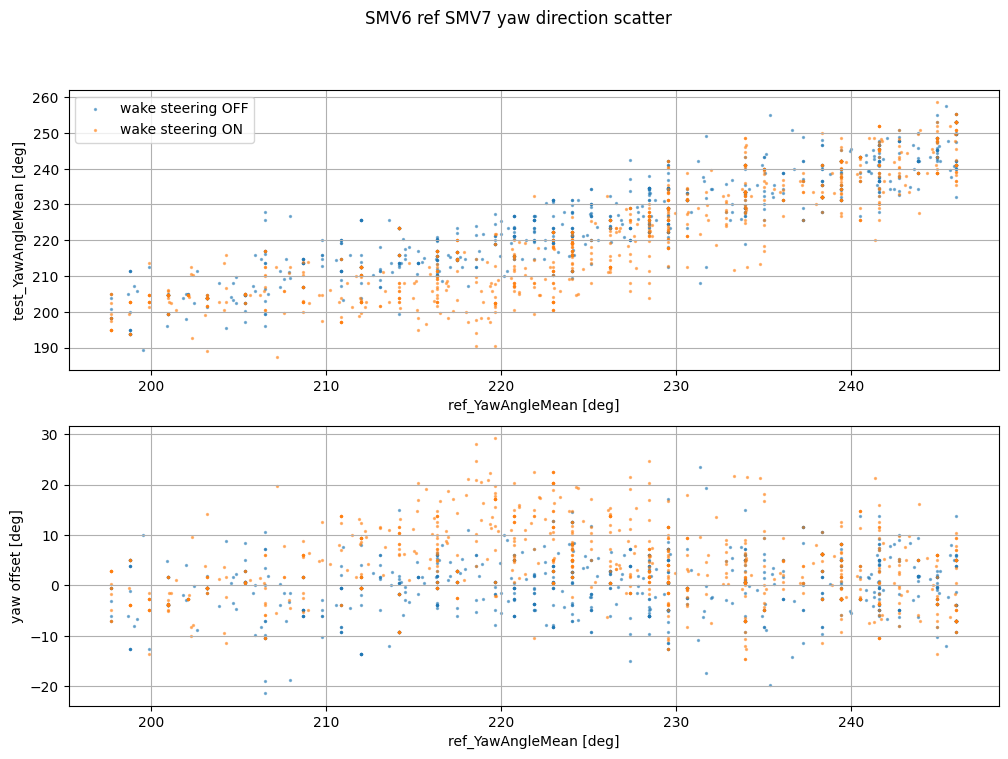

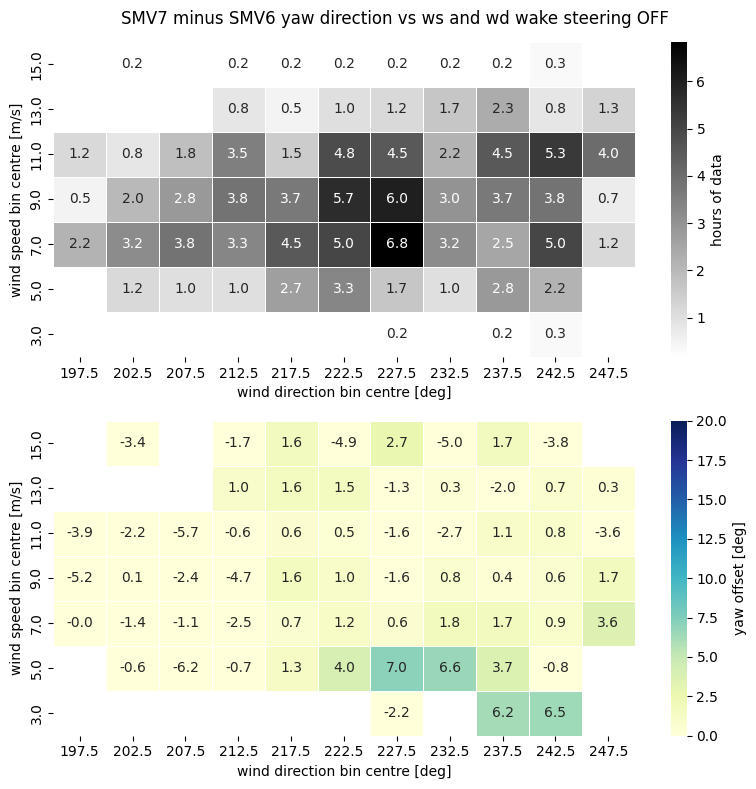

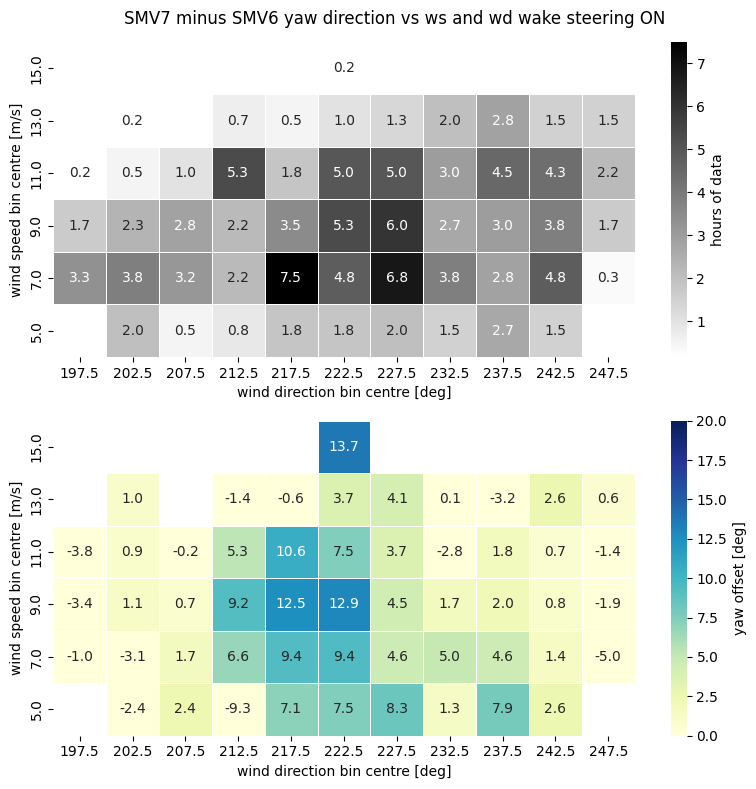

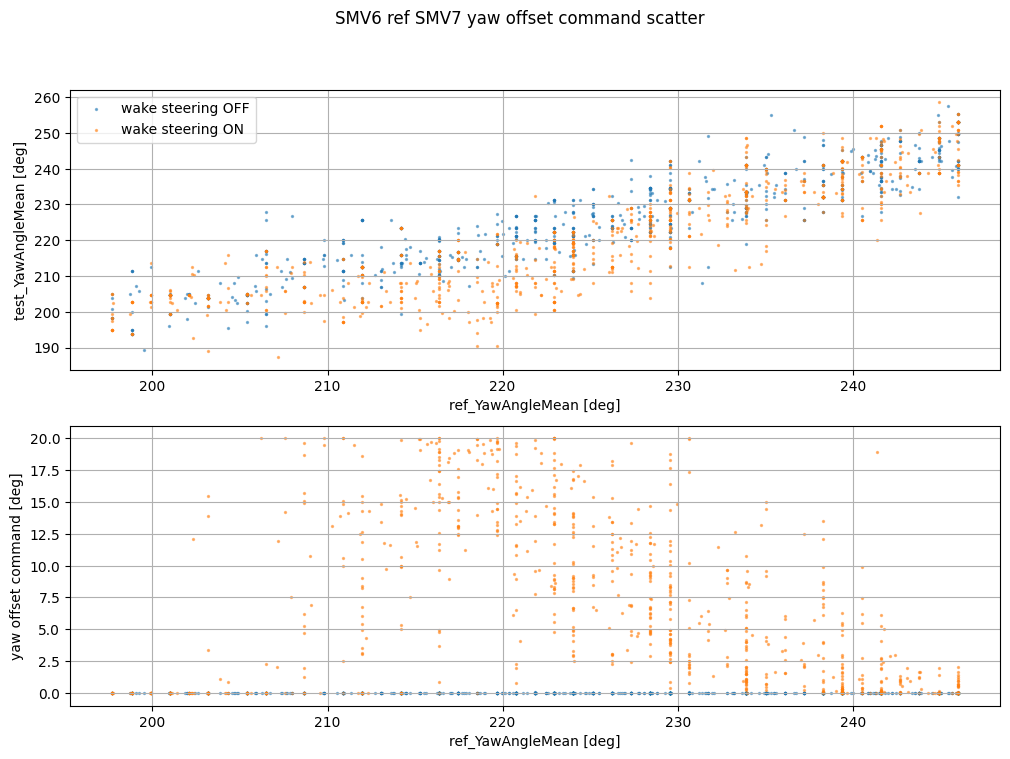

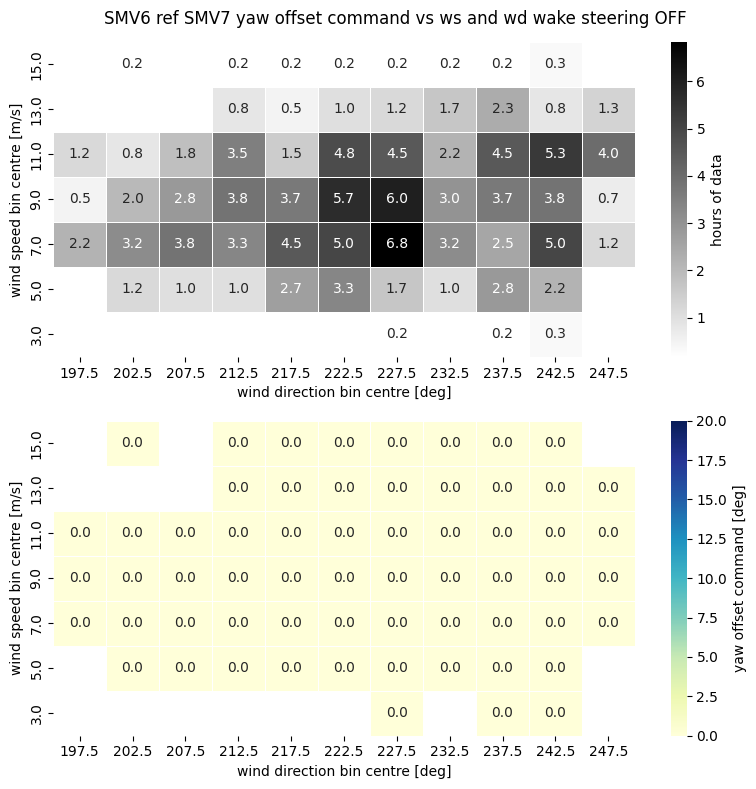

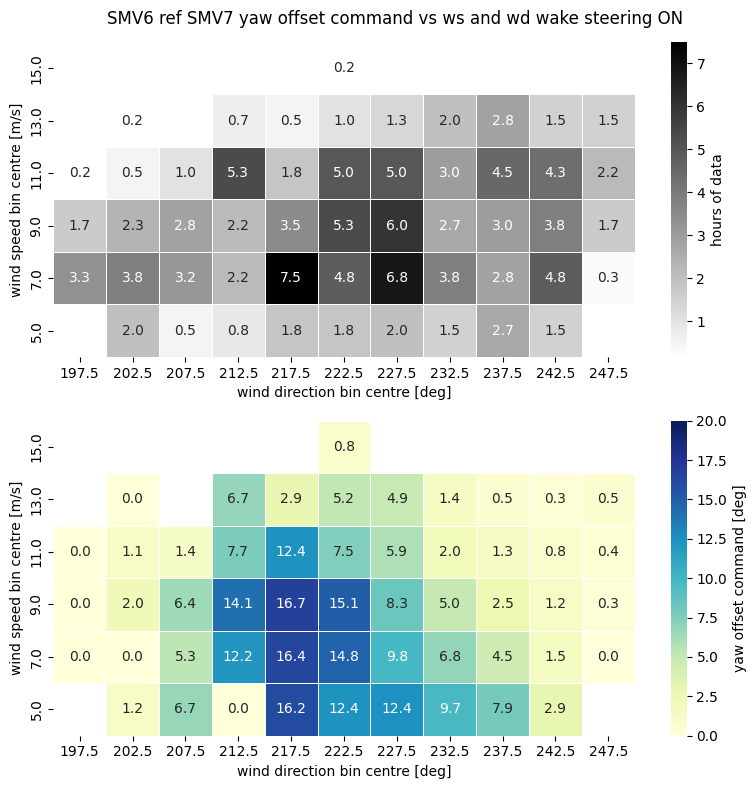

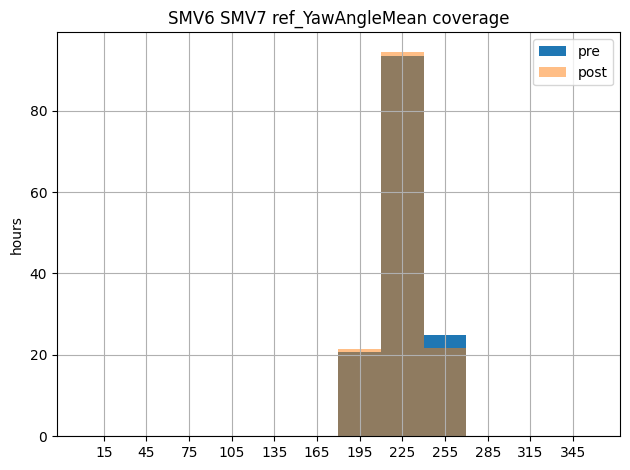

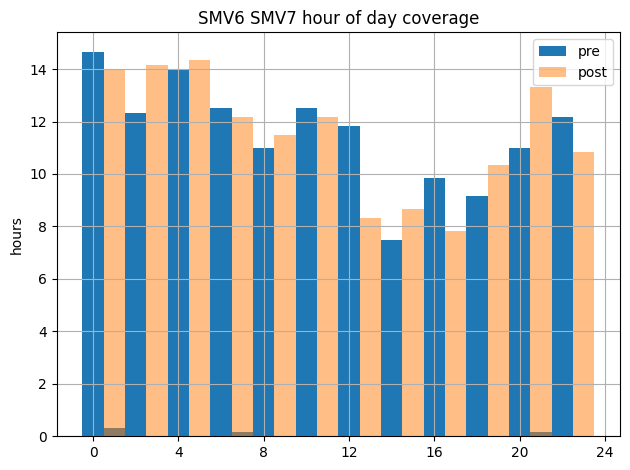

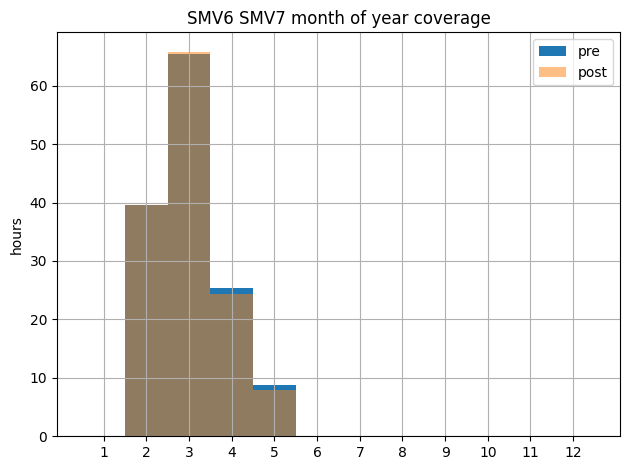

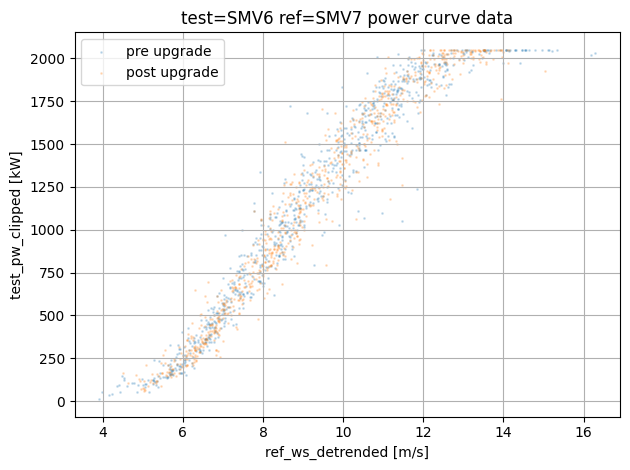

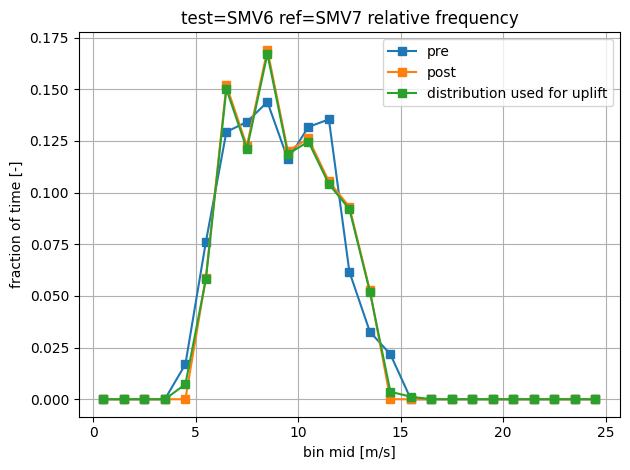

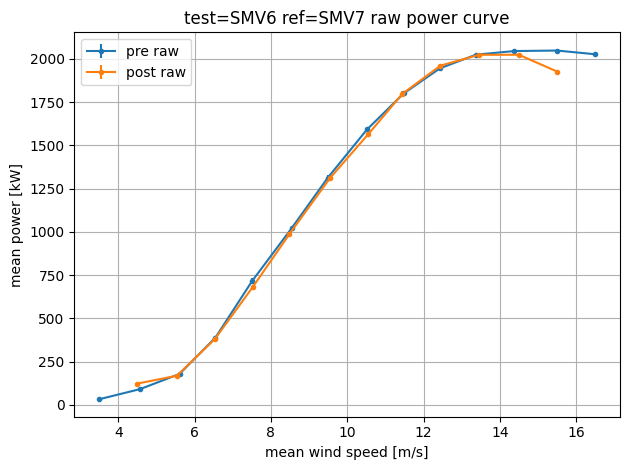

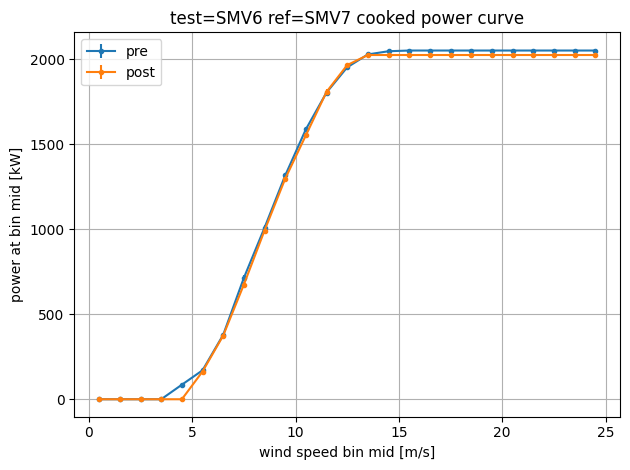

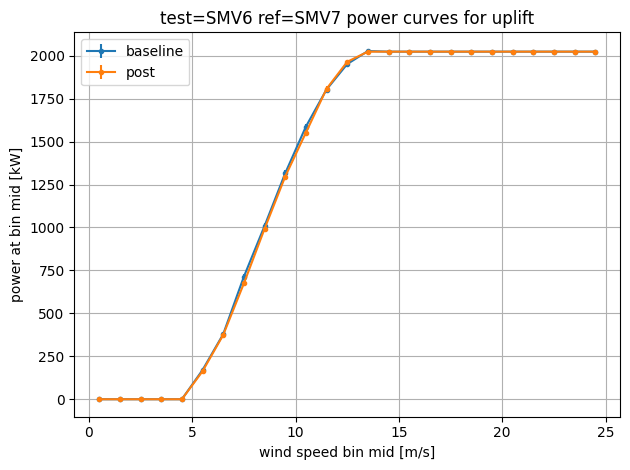

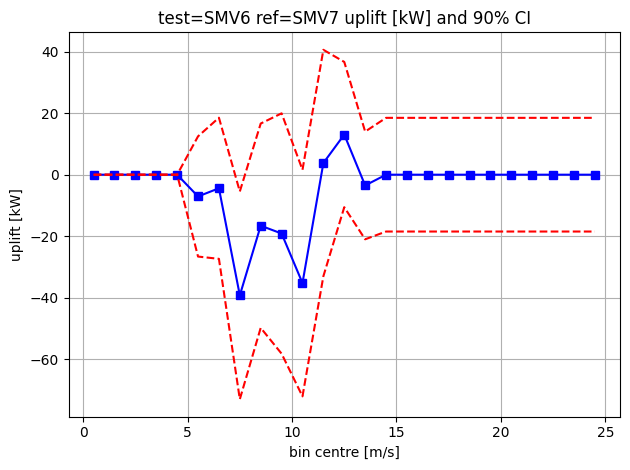

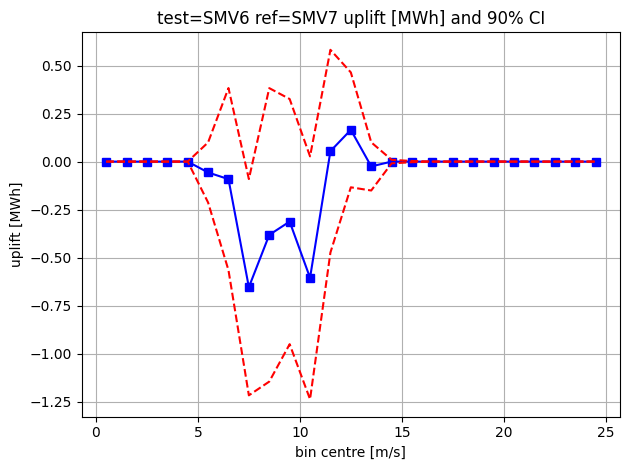

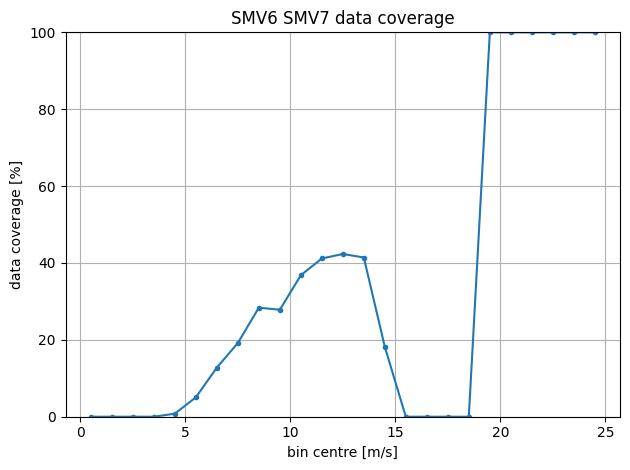

<br>results for test=SMV6 ref=SMV7:<br>

hours pre = 137.8

hours post = 136.0

<br>uplift estimate before adjustments = -1.2 %

<br>power only uplift estimate = -1.2 %

reversed (power only) uplift estimate = -1.1 %<br>

Running block bootstrapping uncertainty analysis n_samples = 400

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
results_per_test_ref_df = run_wind_up_analysis(assessment_inputs)

## print the per turbine results as a nice table

In [ ]:
from examples.smarteole_example import print_smarteole_results

_=print_smarteole_results(results_per_test_ref_df, print_small_table=True)

## calculate the net uplift of this wake steering test

In [ ]:
from wind_up.combine_results import calc_net_uplift
net_p50, net_p95, net_p5 = calc_net_uplift(results_per_test_ref_df, confidence=0.9)
print(f"net P50: {net_p50:.1%}, net P95: {net_p95:.1%}, net P5: {net_p5:.1%}")